# Project 3 report
Authors:
Ignacy Stępka, 148179
Michał Wiliński, 151938

In [1]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import pandas as pd
from xgboost import plot_tree
import os
from warnings import simplefilter as stfu
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if "project3" in os.getcwd():
    os.chdir("..")
from project3.models import PrefXGB, load_data, get_metric

stfu("ignore")

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>Dataset</h1>
</div>

In [2]:
DATA_PATH = "project3/data/employee selection.csv"
ROUNDING = 2
TARGET_MAP = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}
NO_CRITERIA = 4

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>1. Interpretable ML model - XGBoost</h1>
</div>

<div style="background-color: #553300; color: white; text-align: center">
    <h2>1.1 Training & evaluating the model </h2>
</div>

In [3]:
xgb_params = {
    "max_depth": NO_CRITERIA * 2,  # Maximum depth of a tree
    "eta": 0.3,  # Learning rate
    "nthread": 2,  # Number of parallel threads
    "seed": 0,  # Random seed
    "eval_metric": "rmse",  # Evaluation metric
    "monotone_constraints": "("
    + ",".join(["1"] * NO_CRITERIA)
    + ")",  # Monotonic constraints for each criterion (1 = increasing, -1 = decreasing, 0 = no constraint)
    "n_estimators": 1,  # Number of boosting rounds, or trees
}

In [4]:
xgb_results = dict()
pref_xgb = PrefXGB(xgb_params, criteria_nr=NO_CRITERIA)


X_train, X_test, y_train, y_test = load_data(DATA_PATH, TARGET_MAP, NO_CRITERIA)
pref_xgb.model.fit(X_train, y_train)

for metric in [accuracy_score, f1_score, roc_auc_score]:
    metric_train = get_metric(X_train, y_train, pref_xgb.model, metric)
    metric_test = get_metric(X_test, y_test, pref_xgb.model, metric)
    metric_train, metric_test = round(metric_train, ROUNDING), round(metric_test, ROUNDING)
    xgb_results[metric.__name__] = (metric_train, metric_test)

pprint(xgb_results)

{'accuracy_score': (0.85, 0.77),
 'f1_score': (0.78, 0.72),
 'roc_auc_score': (0.82, 0.76)}


<div style="background-color: #553300; color: white; text-align: center">
    <h2>1.2 Interpretability</h2>
</div>

<Axes: >

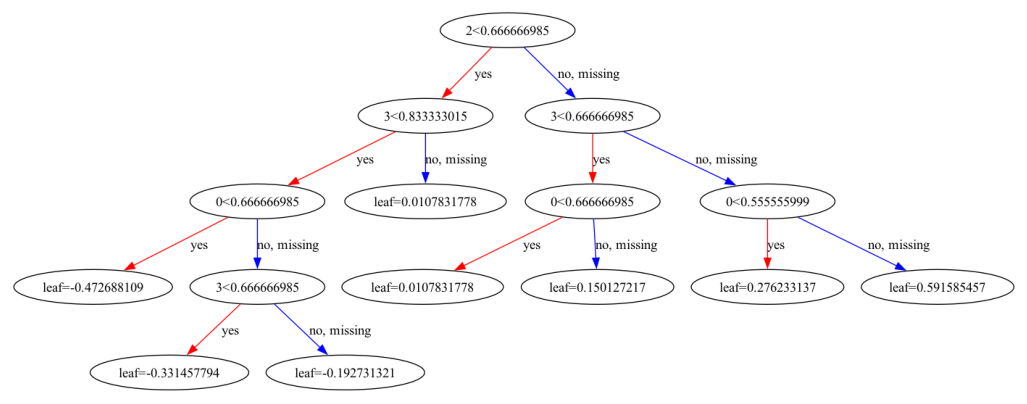

In [5]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_tree(pref_xgb.model, ax=ax, num_trees=0)

In [6]:
booster = pref_xgb.model.get_booster()
booster.get_fscore()

{'0': 3.0, '2': 1.0, '3': 3.0}

In [7]:
booster.get_score(importance_type="gain")

{'0': 2.274850606918335, '2': 61.5543098449707, '3': 7.707414627075195}

In [8]:
booster.get_score(importance_type="weight")

{'0': 3.0, '2': 1.0, '3': 3.0}

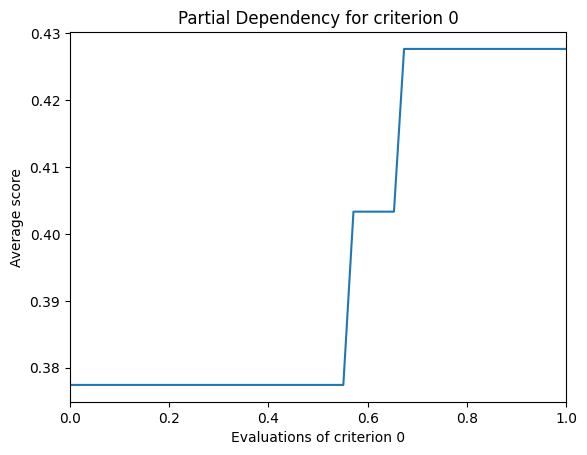

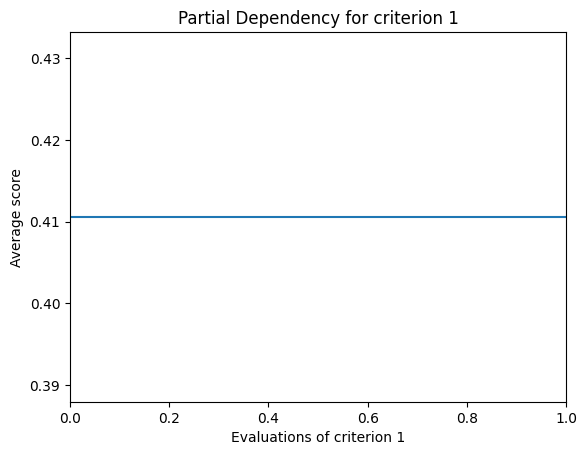

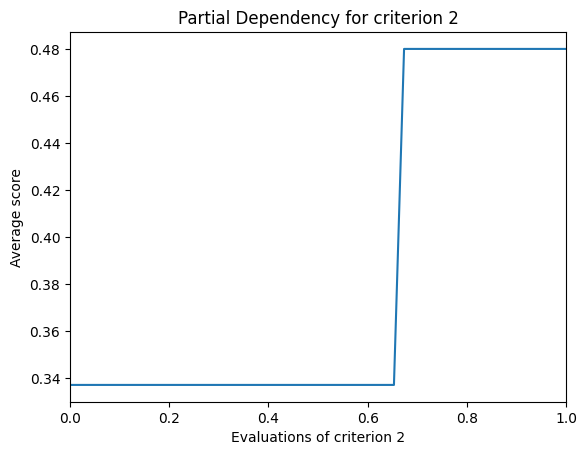

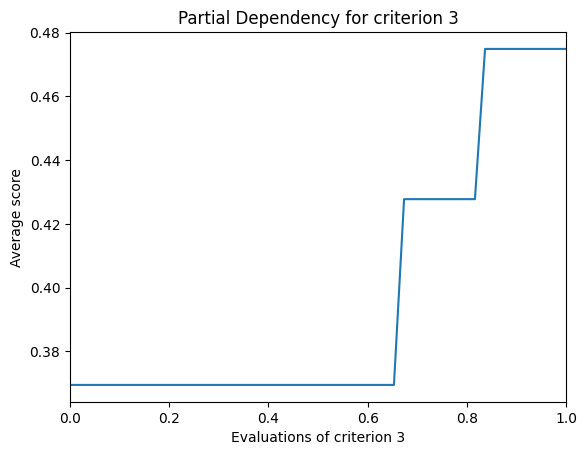

In [9]:
grid = np.linspace(0, 1, 100)
for c in range(NO_CRITERIA):
    grid, y_pred = pref_xgb.partial_dependency(X_train.values, y_train, c)
    fig, ax = plt.subplots()
    ax.plot(grid, y_pred)
    ax.set_xlim(0, 1)
    ax.set_title(f"Partial Dependency for criterion {c}")
    ax.set_xlabel(f"Evaluations of criterion {c}")
    ax.set_ylabel("Average score")

[0, 1, 2, 3, (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


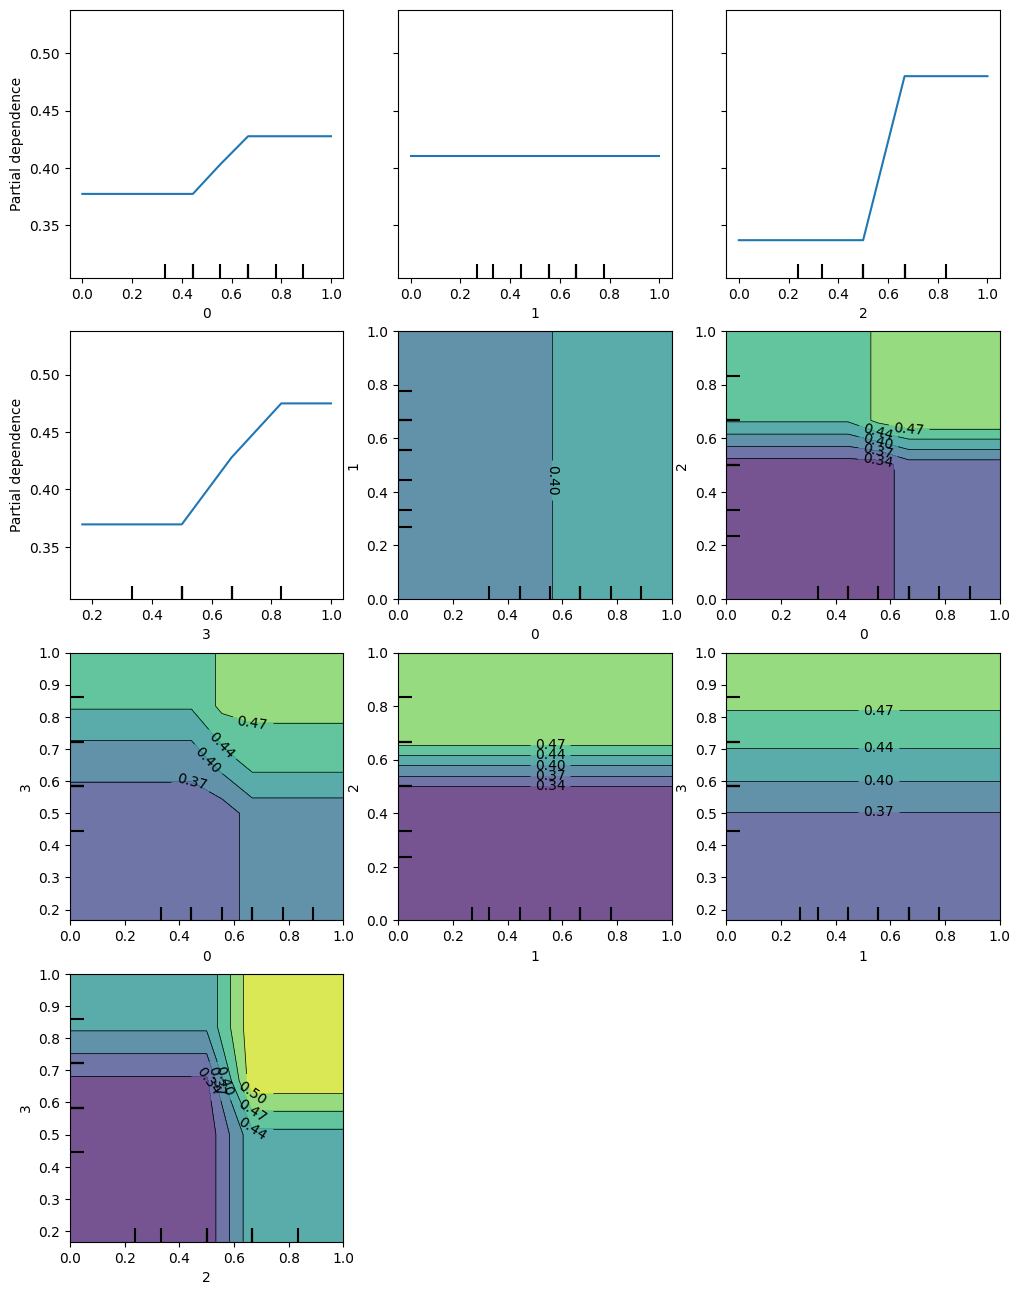

In [10]:
from itertools import combinations
features = list(range(NO_CRITERIA))
features += list(combinations(features, 2))
print(features)
fig, ax = plt.subplots(figsize=(12, 16))
PartialDependenceDisplay.from_estimator(pref_xgb.model, X_train, features, ax=ax)

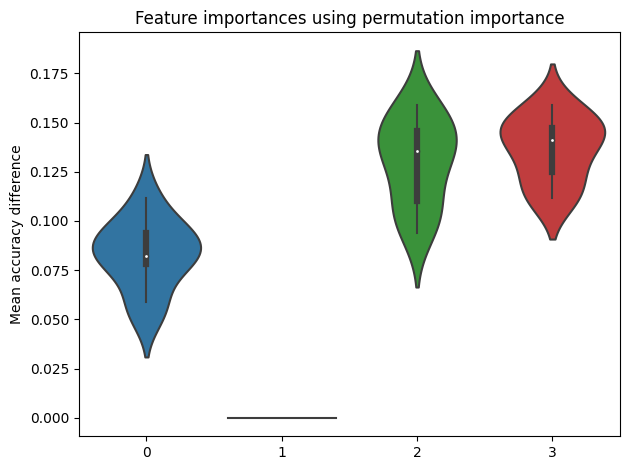

In [11]:
permutation_importance_output = permutation_importance(pref_xgb.model, X_train, y_train, n_repeats=10, random_state=0)
fig, ax = plt.subplots()
sns.violinplot(pd.DataFrame(permutation_importance_output.importances.T), ax=ax)
ax.set_title("Feature importances using permutation importance")
ax.set_ylabel("Mean accuracy difference")
fig.tight_layout()

<div style="background-color: #553300; color: white; text-align: center">
    <h2>1.3 Local decision explanation</h2>
</div>

In [12]:
NO_SAMPLES = 3
RANDOM_STATE = 0
sample = X_test.sample(NO_SAMPLES, random_state=RANDOM_STATE)
pprint(sample)

            0         1         2         3
137  0.555556  0.333333  0.500000  0.833333
62   0.666667  0.444444  0.666667  0.666667
316  0.555556  0.666667  0.500000  0.666667



<div style="background-color: #553300; color: white; text-align: left">
    <p>Following the instruction, we also present marginal value functions on the same y-axis scale. What is interesting is that the functions inrease mostly in the latter part of their x range. The explanation for this is relatively straightworward: our dataset comprises movies that score either very well or very bad on most criteria. We don't have much movies that are a middleground between good and bad, therefore there is no need for much variability somewhere in the middle of these marginal value functions.</p>
</div>

***


<div style="background-color: #993300; color: white; text-align: center">
    <h1>2. Interpretable neural MCDA method - ANN-UTADIS</h1>
</div>


In [13]:
from project3.models.ann_utadis.utils import *
from project3.models.ann_utadis.uta import Uta
from project3.models.ann_utadis.norm_layer import NormLayer

<div style="background-color: #553300; color: white; text-align: center">
    <h2>2.1 Training & evaluating the model</h2>
</div>

In [14]:
MODEL_SAVE_PATH = "project3/weights/ann_utadis.pt2"

In [15]:
X_train_pt = X_train.values.reshape(-1, 1, NO_CRITERIA)
X_test_pt = X_test.values.reshape(-1, 1, NO_CRITERIA)
y_train_pt = y_train.values
y_test_pt = y_test.values
print(X_train_pt.shape, X_test_pt.shape)
print(y_train_pt.shape, y_test_pt.shape)

(170, 1, 4) (43, 1, 4)
(170,) (43,)


In [16]:
train_dataloader = CreateDataLoader(X_train_pt, y_train_pt)
test_dataloader = CreateDataLoader(X_test_pt, y_test_pt)

In [17]:
uta = Uta(NO_CRITERIA, 30)
model = NormLayer(uta, NO_CRITERIA)
(
    best_acc,
    best_auc,
    best_f1,
    stats_train,
    stats_test,
) = Train(
    model,
    train_dataloader,
    test_dataloader,
    MODEL_SAVE_PATH,
    epoch_nr=200,
    lr=0.0001,
    slope_decrease=True,
)
print(f"Best accuracy: {best_acc:.2f}")
print(f"Best AUC: {best_auc:.2f}")
print(f"Best F1: {best_f1:.2f}")

100%|██████████| 200/200 [00:00<00:00, 385.94it/s]

Best accuracy: 0.91
Best AUC: 0.97
Best F1: 0.88


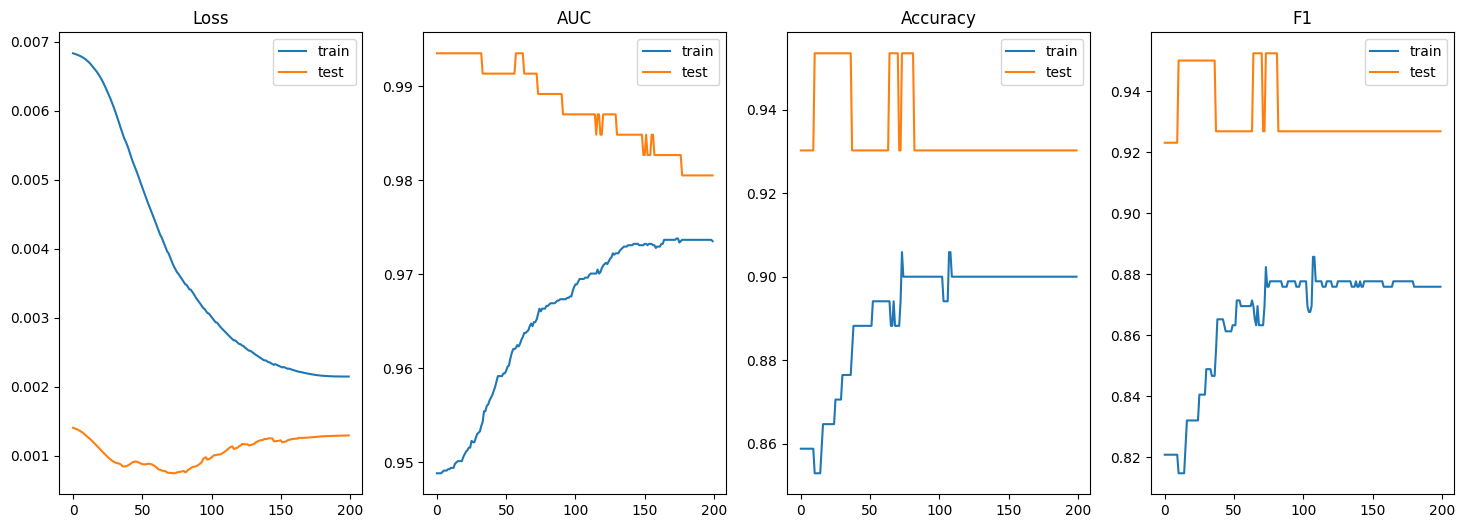

In [18]:
fig = plt.figure(figsize=(18,6))

ax = fig.add_subplot(141)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,4,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,4,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

ax = fig.add_subplot(1,4,4)
ax.plot(stats_train.f1_scores,label='train')
ax.plot(stats_test.f1_scores,label='test')
ax.set_title('F1')
ax.legend()


<div style="background-color: #553300; color: white; text-align: center">
    <h2>2.2 Interpretability</h2>
</div>

In [19]:
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [20]:
hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val, NO_CRITERIA)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
outs = outs[::3] - outs[::3][0]
outs = outs / outs[-1].sum()

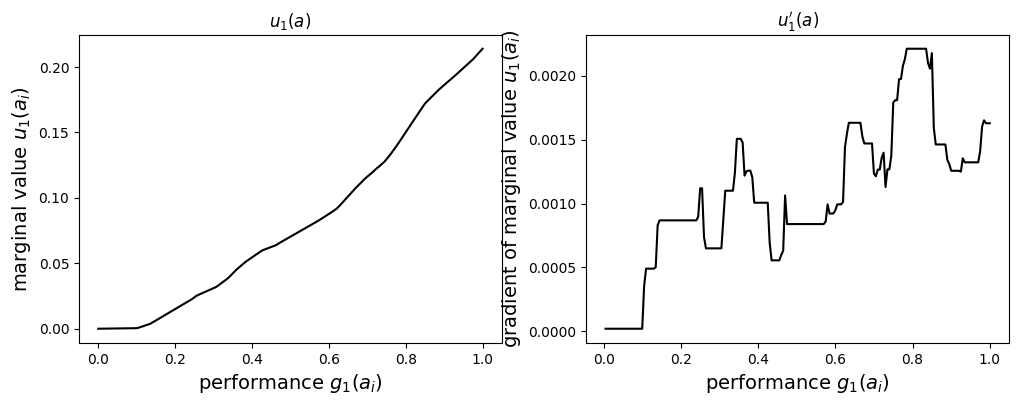

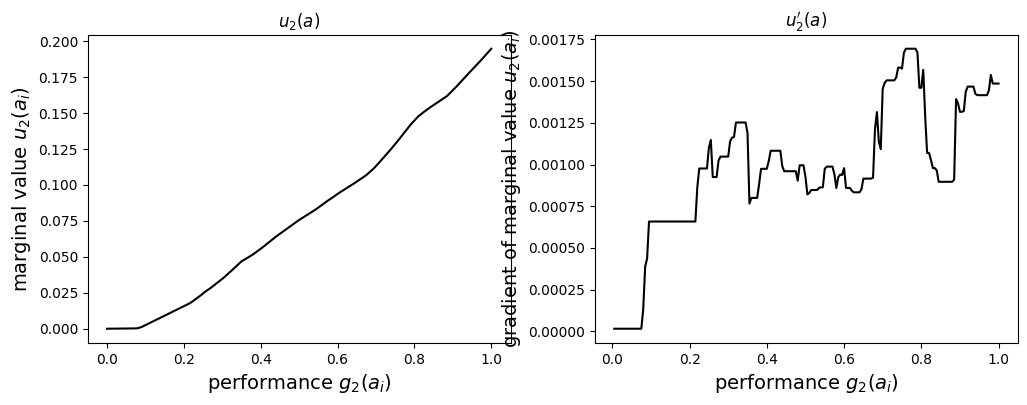

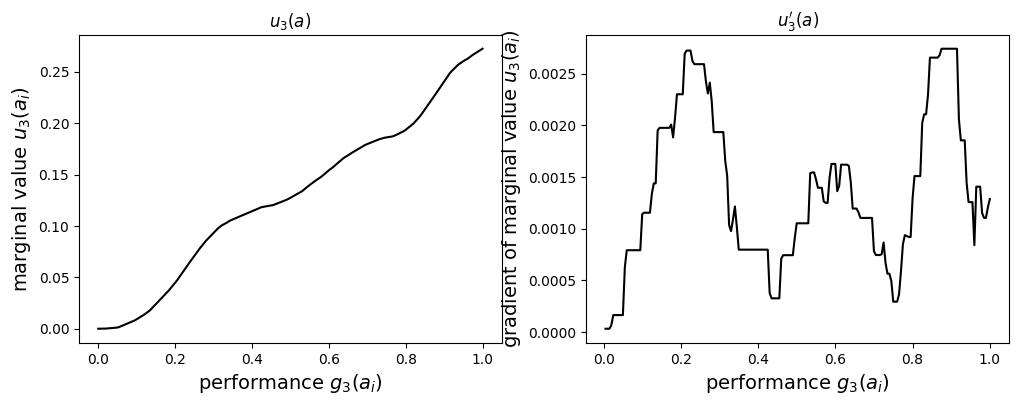

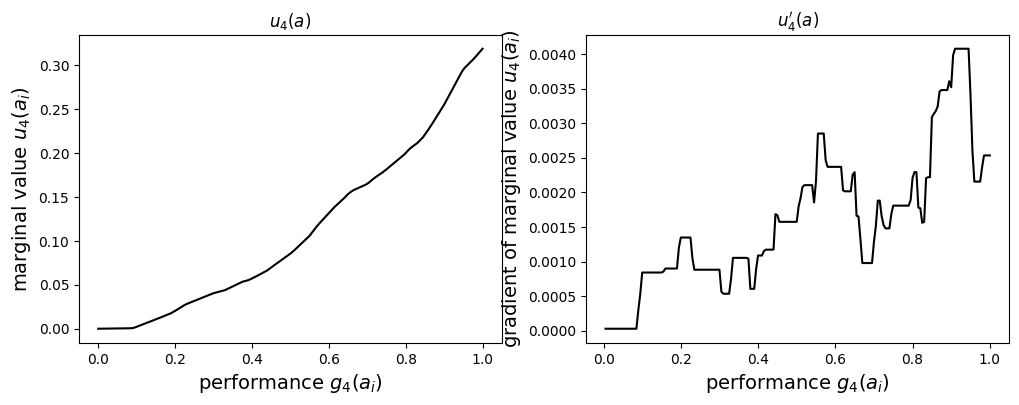

In [21]:
for i in range(NO_CRITERIA):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12,4))  
    ax = fig.add_subplot(121)
    ax.set_title(f'$u_{criterion_number}(a)$')
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i]-outs[:-1, i], color="black")
    ax.set_ylabel(f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()

<div style="background-color: #553300; color: white; text-align: center">
    <h2>2.3 Local decision explanation</h2>
</div>

In [22]:
NO_SAMPLES = 3
RANDOM_STATE = 0
sample = X_test.sample(NO_SAMPLES, random_state=RANDOM_STATE)
pprint(sample)

            0         1         2         3
137  0.555556  0.333333  0.500000  0.833333
62   0.666667  0.444444  0.666667  0.666667
316  0.555556  0.666667  0.500000  0.666667


***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>3. Neural network with a few layers & nonlinear activation functions</h1>
</div>


<div style="background-color: #553300; color: white; text-align: center">
    <h2>3.1 Training & evaluating the model</h2>
</div>

In [23]:
from project3.models.preference_net import train_model, test_model

In [24]:
preference_nn_params = {
        'input_size': 4,
        'hidden_size': 8,
        'num_epochs': 200,
        'learning_rate': 0.01,
        'path': "project3/weights/preference_net.pth",
}

model = train_model(train_dataloader, test_dataloader, **preference_nn_params)
print("TRAIN SET PERFORMANCE")
test_model(model, train_dataloader)
print()
print("TEST SET PERFORMANCE")
test_model(model, test_dataloader)

100%|██████████| 200/200 [00:00<00:00, 536.33it/s, Loss=0.217, Test Accuracy=0.86]


TRAIN SET PERFORMANCE
Accuracy Score: 0.9235
F1 Score: 0.9051
ROC AUC: 0.9196
Precision-Recall AUC: 0.9257

TEST SET PERFORMANCE
Accuracy Score: 0.8605
F1 Score: 0.8500
ROC AUC: 0.8593
Precision-Recall AUC: 0.8986


<div style="background-color: #553300; color: white; text-align: center">
    <h2>3.2 Interpretability</h2>
</div>

<div style="background-color: #553300; color: white; text-align: center">
    <h2>3.3 Local decision explanation</h2>
</div>

***
<div style="background-color: #993300; color: white; text-align: center">
    <h1>Final conclusions</h1>
</div>
